<a href="https://colab.research.google.com/github/ZaimaSartajTaheri/ResearchCodes/blob/main/Niloy_DenseNet121_NonTuned_v1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.layers import *
from keras.models import *
from keras.preprocessing import image
from tensorflow.keras import datasets, layers, models
import tensorflow_hub as hub
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
import tensorboard

X_train_path = "/content/drive/MyDrive/Research/v1_0/Train"
X_test_path = "/content/drive/MyDrive/Research/v1_0/Test"
Val_test_path = "/content/drive/MyDrive/Research/v1_0/Val"

# design the traing dataset
train_datagen = image.ImageDataGenerator(
    rescale=1/255,
    zoom_range=0.1,
    samplewise_center=True,
    samplewise_std_normalization=True
)

X_train = train_datagen.flow_from_directory(
    X_train_path,
    target_size=(224, 224),
    batch_size=32,
    shuffle=True, 
    class_mode = "categorical"
)

# design the test dataset
# test_datagen = image.ImageDataGenerator(rescale=1/255)

X_test = train_datagen.flow_from_directory(
    X_test_path,
    target_size=(224, 224),
    batch_size=1,
    shuffle=False,
    class_mode= "categorical"
)

# design the test dataset
# Val_datagen = image.ImageDataGenerator(rescale=1/255)

Val_test = train_datagen.flow_from_directory(
    Val_test_path,
    target_size=(224, 224),
    batch_size=1,
    shuffle=False,
    class_mode= "categorical"
)

#Getting numbers of samples and classes
nb_train_samples = len(X_train.filenames)  
nb_train_samples
num_classes=len(X_train.class_indices)
num_classes


from keras.utils.np_utils import to_categorical 
# get the class lebels for the training data, in the original order  
train_labels = X_train.classes  
train_labels = to_categorical(train_labels, num_classes=num_classes) 

validation_labels = Val_test.classes  
validation_labels = to_categorical(validation_labels, num_classes=num_classes) 

test_labels = X_test.classes  
test_labels = to_categorical(test_labels, num_classes=num_classes) 

Found 8376 images belonging to 3 classes.
Found 2790 images belonging to 3 classes.
Found 2792 images belonging to 3 classes.


29097984/29084464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
_____________________________

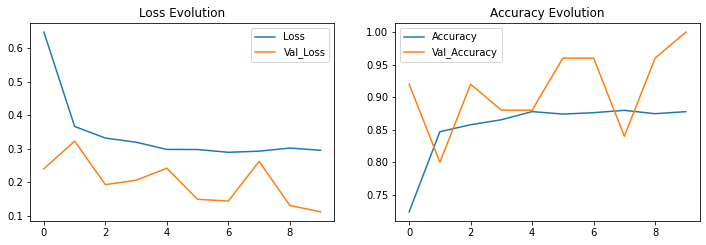

In [2]:
# TL Model
from keras.applications.densenet import DenseNet121
base_model = DenseNet121(
    include_top=False, weights='imagenet',input_shape = (224, 224, 3)
)

# changing the output layer of the TL layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(.5)(x)
predictions = Dense(X_train.num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model.compile(
    optimizer='adam',  # optimizer chooses the type of gradient descent one want to apply
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

r = model.fit(X_train, epochs=10, steps_per_epoch = 262, validation_data=(
    Val_test), validation_steps = 25)

# evaluate on test set
model.evaluate(X_test)


Confusion matrix, without normalization
[[831  94   5]
 [148 777   5]
 [  4  31 895]]


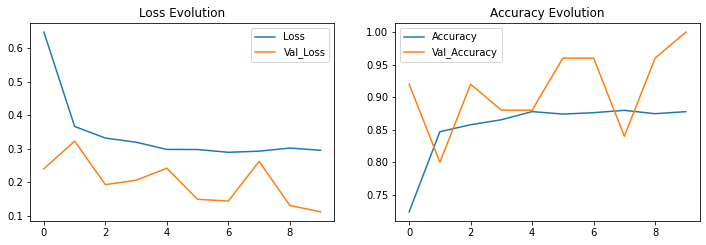

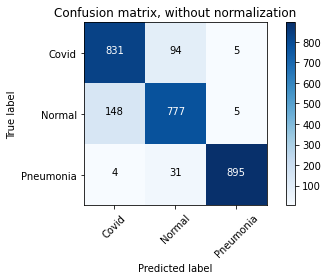

In [8]:
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Val_Loss')
plt.legend()
plt.title('Loss Evolution')
plt.savefig('lossCurve')

plt.subplot(2, 2, 2)
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Val_Accuracy')
plt.legend()
plt.title('Accuracy Evolution')
plt.savefig('accuracyCurve')

# Classification Report
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import numpy as np

pred = model.predict(X_test)
y_pred=np.argmax(pred, axis=1)
y_test=np.argmax(test_labels, axis=1)

cnf_matrix=confusion_matrix(y_test, y_pred)
pd.DataFrame(classification_report(y_test,y_pred,output_dict=True))

# Confusion Matrix
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting normalize=True.
    """
    import itertools
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('ConfusionMatrix')

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Covid', 'Normal', 'Pneumonia'],
                    title='Confusion matrix, without normalization')

# plt.figure(figsize=(12, 8))

# plt.subplot(2, 2, 1)
# plt.plot(r.history['loss'], label='Loss')
# plt.plot(r.history['val_loss'], label='Val_Loss')
# plt.legend()
# plt.title('Loss Evolution')
# plt.savefig('lossCurve')

# plt.subplot(2, 2, 2)
# plt.plot(r.history['accuracy'], label='Accuracy')
# plt.plot(r.history['val_accuracy'], label='Val_Accuracy')
# plt.legend()
# plt.title('Accuracy Evolution')
# plt.savefig('accuracyCurve')